# Preparation: Imports, functions and Audio Trim


In [72]:
import essentia.standard as es
import numpy as np
import os
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [73]:
def trim_wave(wave, idx):
    frame_size = len(wave)
    pitchYin = es.PitchYin(frameSize=frame_size)
    pitch, pitchconf = pitchYin(wave)
    print(pitch, pitchconf)
    if pitchconf < 0.8:
        raise ValueError("Pitch confidence too low")
    period = 1.0 / pitch
    period_samples = int(period * 44100)

    zero_crossings = np.where(np.diff(np.sign(wave)) > 0)[0]
    if len(zero_crossings) > 0:
        start = zero_crossings[0]
        trimmed_wave = wave[start : start + period_samples]
    else:
        trimmed_wave = wave[:period_samples]

    return trimmed_wave


def frequency(waves):
    for wave in waves:
        pitchYin = es.PitchYin(frameSize=len(wave))
        pitch, pitchconf = pitchYin(wave)
        print(pitch)

In [74]:
audio_dir = "def samples"
audio_files = sorted(os.listdir(audio_dir))
audio_data = []
for file in audio_files:
    loader = es.MonoLoader(filename=os.path.join(audio_dir, file), sampleRate=44100)
    audio = loader()
    audio_data.append(audio)
audio_data = np.array(audio_data)
audio_data_trimmed = []
for i in range(len(audio_data)):
    wave = audio_data[i]
    trimmed_wave = trim_wave(wave, i)
    audio_data_trimmed.append(trimmed_wave)

audios = np.array(audio_data_trimmed)
# pot_values = np.linspace(0, 4, len(audio_data_trimmed))
pot_values = np.linspace(0, 4, len(audio_data_trimmed))

440.05621337890625 0.9994421601295471
440.03936767578125 0.9994345307350159
440.09478759765625 0.9993952512741089
440.11334228515625 0.9992413520812988
440.1029968261719 0.9989595413208008
440.0918884277344 0.9986041188240051
440.1206970214844 0.9982636570930481
440.1067810058594 0.9974650144577026
440.218017578125 0.9980720281600952
440.10198974609375 0.9990507960319519
440.08587646484375 0.9987959861755371
440.09356689453125 0.9973345398902893
440.0983581542969 0.9991087317466736
440.05987548828125 0.9990563988685608
440.07025146484375 0.9989929795265198
440.05804443359375 0.9983398914337158
440.056640625 0.995542049407959
440.0585021972656 0.995547354221344
440.052734375 0.99550861120224
440.06170654296875 0.9955691695213318


# Linear Regression


In [121]:
from sklearn.linear_model import LinearRegression

# Initialize the linear regressor
lin_reg = LinearRegression()

# Train a Linear Regression model for each target variable
models = [
    LinearRegression().fit(pot_values.reshape(-1, 1), audios[:, i])
    for i in range(audios.shape[1])
]


# Define a function to predict using the trained models
def predicted_LinearReg(pot_value):
    return np.array([model.predict([[pot_value]])[0] for model in models])

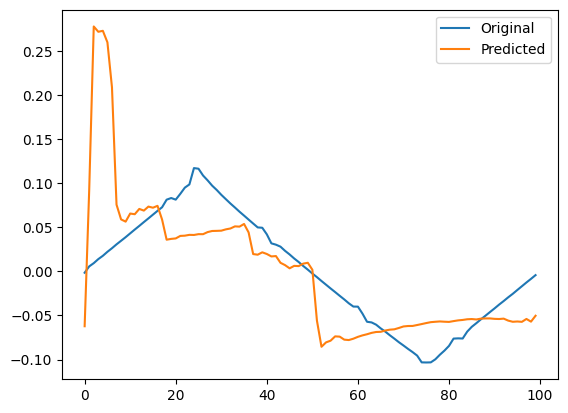

In [127]:
plt.plot(audio_data_trimmed[1], label="Original")
plt.plot(predicted_LinearReg(pot_values[15]), label="Predicted")
plt.legend()
plt.show()

# Linear Interpolation


In [75]:
def predicted_output_lininter(pot_value, pot_values=pot_values, audios=audios):
    if pot_value < 0 or pot_value > 4:
        raise ValueError("Pot value must be between 0 and 4")
    print(pot_values.shape, audios.shape)
    interpolator = interp1d(pot_values, audios, axis=0, kind="linear")
    return interpolator(pot_value)

In [76]:
predicted_lininter_vals = np.array(
    predicted_output_lininter(pot_value) for pot_value in pot_values
)

# Random Forest


In [77]:
param_grid = {
    "n_estimators": [100, 200, 300, 400, 500],
    "max_depth": [None, 5, 10, 15, 20, 25, 30],
    "min_samples_split": [2, 5, 10, 15, 20],
    "min_samples_leaf": [1, 2, 5, 10, 15],
}

rf = RandomForestRegressor()
rf_grid = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1)
rf_grid.fit(pot_values.reshape(-1, 1), audios[:, 0])
best_params = rf_grid.best_params_

models = [
    RandomForestRegressor(
        n_estimators=best_params["n_estimators"],
        max_depth=best_params["max_depth"],
        min_samples_split=best_params["min_samples_split"],
        min_samples_leaf=best_params["min_samples_leaf"],
    ).fit(pot_values.reshape(-1, 1), audios[:, i])
    for i in range(audios.shape[1])
]


def predicted_RF(pot_value):
    return np.array([model.predict([[pot_value]])[0] for model in models])

In [78]:
predicted_output_RF = []
for pot_value in pot_values:
    predicted_output_RF.append(predicted_RF(pot_value))
predicted_output_RF = np.array(predicted_output_RF)

In [79]:
print(predicted_output_RF[0])

[-0.00172933  0.00347982  0.00745941  0.01179199  0.01570567  0.01994619
  0.02411051  0.02855326  0.03313273  0.03696472  0.04223684  0.04830882
  0.04922414  0.0510319   0.05796936  0.06272024  0.06712474  0.07105906
  0.07648844  0.08018066  0.08284871  0.08731913  0.09296519  0.09663066
  0.107058    0.11787567  0.1118102   0.10771322  0.10220693  0.09853902
  0.09387319  0.09138916  0.08717845  0.07548879  0.06732981  0.06923798
  0.06237295  0.06008148  0.05515828  0.05067006  0.04731455  0.04124135
  0.03118286  0.02979777  0.02674266  0.0190977   0.01774414  0.01574412
  0.00829793  0.00280619 -0.0031722  -0.00728302 -0.01219177 -0.01360138
 -0.02014028 -0.02825907 -0.0307488  -0.03304006 -0.03574849 -0.04249939
 -0.04290222 -0.04824351 -0.05556356 -0.05798309 -0.06143707 -0.06536774
 -0.06949351 -0.07330963 -0.07691152 -0.08090586 -0.08446462 -0.08813497
 -0.09209961 -0.09452789 -0.09826904 -0.10509043 -0.10587952 -0.10182383
 -0.09589172 -0.09176727 -0.08654104 -0.08118663 -0

# RNN


In [80]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler

# Standardize the pot_values
scaler = StandardScaler()
pot_values_scaled = scaler.fit_transform(pot_values.reshape(-1, 1))

# Define the model
model = Sequential()
model.add(Bidirectional(LSTM(64, input_shape=(None, 1))))
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(audios.shape[1]))  # Adjusted to match the number of output samples

# Compile the model with a smaller learning rate
opt = Adam(lr=0.001)
model.compile(loss="mean_squared_error", optimizer=opt)

# Create the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.95, patience=25, min_delta=5e-7)

# Reshape the data to fit the model
X = pot_values_scaled.reshape(len(pot_values_scaled), 1, 1)
Y = audios

# Train the model for more epochs with the ReduceLROnPlateau callback
model.fit(X, Y, epochs=3000, batch_size=128, callbacks=[reduce_lr], verbose=0)


# Define a function to make predictions
def predicted_RNN(pot_value):
    pot_value_scaled = scaler.transform(np.array([[pot_value]]))
    return model.predict(pot_value_scaled.reshape(1, 1, 1))[0]

/Users/javierechavarri/miniconda3/envs/TFG/lib/python3.9/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [81]:
predicted_RNN_values = np.array([predicted_RNN(pot_value) for pot_value in pot_values])

1/1 [==============================] - 0s 15ms/step


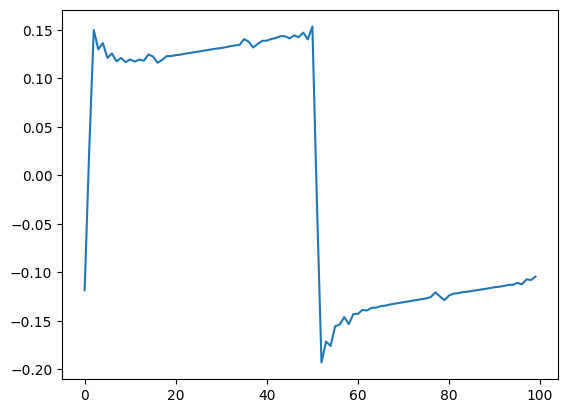

In [82]:
plt.plot(predicted_RNN_values[9])

# Graphs


In [83]:
print(pot_values)

[0.         0.21052632 0.42105263 0.63157895 0.84210526 1.05263158
 1.26315789 1.47368421 1.68421053 1.89473684 2.10526316 2.31578947
 2.52631579 2.73684211 2.94736842 3.15789474 3.36842105 3.57894737
 3.78947368 4.        ]


## MSE


### Random Forest


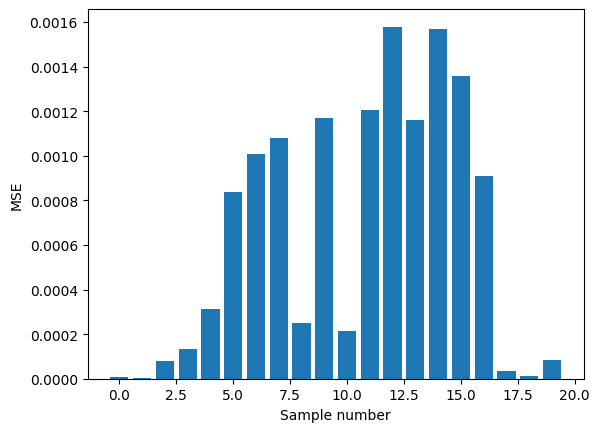

0.0006498704130296621


In [84]:
assert len(predicted_output_RF) == len(audio_data_trimmed)
mse_vals = []
for predicted_output_val, audio_data_trim in zip(
    predicted_output_RF, audio_data_trimmed
):
    mse_vals.append(mean_squared_error(predicted_output_val, audio_data_trim))

plt.bar(range(len(mse_vals)), mse_vals)
plt.xlabel("Sample number")
plt.ylabel("MSE")
plt.show()
print(np.mean(mse_vals))

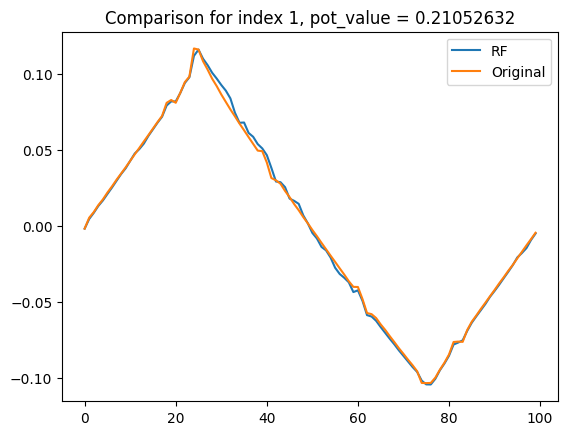

In [85]:
plt.plot(predicted_output_RF[1], label="RF")
plt.plot(audios[1], label="Original")
plt.title("Comparison for index 1, pot_value = 0.21052632")
plt.legend()
plt.show()

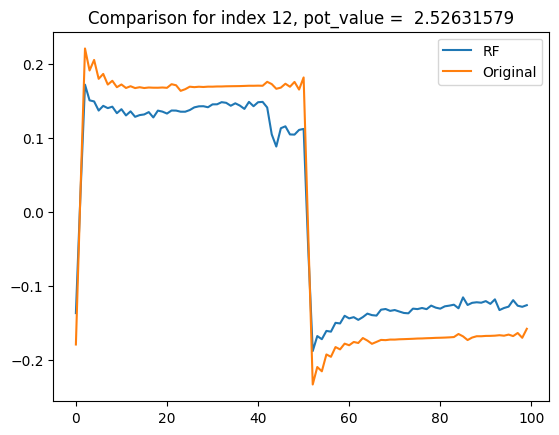

In [86]:
plt.plot(predicted_output_RF[12], label="RF")
plt.plot(audios[12], label="Original")
plt.title("Comparison for index 12, pot_value =  2.52631579")
plt.legend()
plt.show()

### RNN


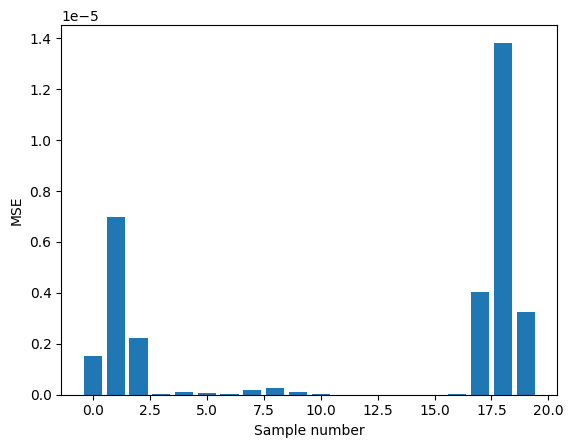

1.6368789e-06


In [88]:
assert len(predicted_RNN_values) == len(audio_data_trimmed)
mse_vals = []
for predicted_output_val, audio_data_trim in zip(
    predicted_RNN_values, audio_data_trimmed
):
    mse_vals.append(mean_squared_error(predicted_output_val, audio_data_trim))

plt.bar(range(len(mse_vals)), mse_vals)
plt.xlabel("Sample number")
plt.ylabel("MSE")
plt.show()
print(np.mean(mse_vals))

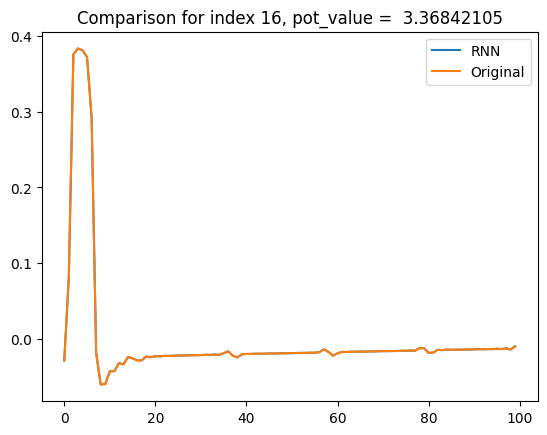

In [89]:
plt.plot(predicted_RNN_values[16], label="RNN")
plt.plot(audios[16], label="Original")
plt.title("Comparison for index 16, pot_value =  3.36842105")
plt.legend()
plt.show()

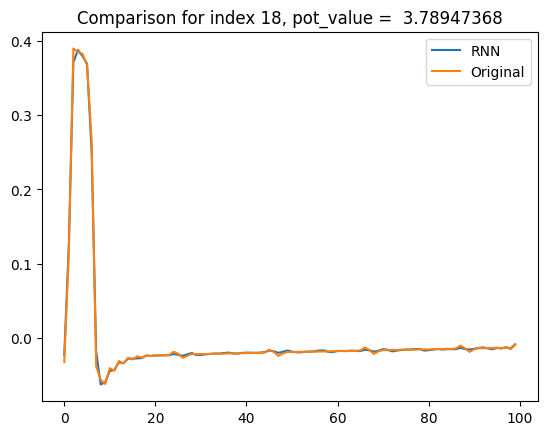

In [90]:
plt.plot(predicted_RNN_values[18], label="RNN")
plt.plot(audios[18], label="Original")
plt.title("Comparison for index 18, pot_value =  3.78947368")
plt.legend()
plt.show()

### Linear Interpolation


In [99]:
pot_values_new = []
for i in range(len(pot_values) - 1):
    pot_values_new.append((pot_values[i] + pot_values[i + 1]) / 2)
print(pot_values_new)

[0.10526315789473684, 0.3157894736842105, 0.5263157894736842, 0.7368421052631579, 0.9473684210526315, 1.1578947368421053, 1.3684210526315788, 1.5789473684210527, 1.789473684210526, 2.0, 2.2105263157894735, 2.4210526315789473, 2.631578947368421, 2.8421052631578947, 3.052631578947368, 3.263157894736842, 3.4736842105263155, 3.6842105263157894, 3.894736842105263]


In [97]:
inter_pred_LI = []
inter_pred_RNN = []
inter_pred_RF = []
for pot_value in pot_values_new:
    inter_pred_LI.append(predicted_output_lininter(pot_value))
    inter_pred_RNN.append(predicted_RNN(pot_value))
    inter_pred_RF.append(predicted_RF(pot_value))

(20,) (20, 100)
1/1 [==============================] - 0s 30ms/step
(20,) (20, 100)
1/1 [==============================] - 0s 24ms/step
(20,) (20, 100)
1/1 [==============================] - 0s 18ms/step
(20,) (20, 100)
1/1 [==============================] - 0s 21ms/step
(20,) (20, 100)
1/1 [==============================] - 0s 20ms/step
(20,) (20, 100)
1/1 [==============================] - 0s 21ms/step
(20,) (20, 100)
1/1 [==============================] - 0s 18ms/step
(20,) (20, 100)
1/1 [==============================] - 0s 19ms/step
(20,) (20, 100)
1/1 [==============================] - 0s 19ms/step
(20,) (20, 100)
1/1 [==============================] - 0s 18ms/step
(20,) (20, 100)
1/1 [==============================] - 0s 20ms/step
(20,) (20, 100)
1/1 [==============================] - 0s 19ms/step
(20,) (20, 100)
1/1 [==============================] - 0s 17ms/step
(20,) (20, 100)
1/1 [==============================] - 0s 19ms/step
(20,) (20, 100)
1/1 [===========================

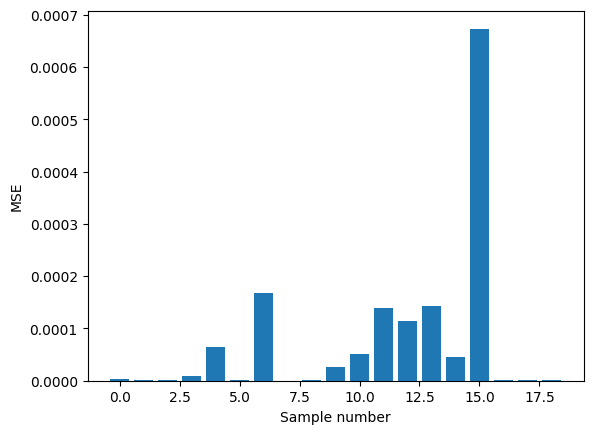

7.618019414118774e-05


In [98]:
assert len(inter_pred_LI) == len(inter_pred_RNN)
mse_vals = []
for predicted_output_val, audio_data_trim in zip(inter_pred_LI, inter_pred_RNN):
    mse_vals.append(mean_squared_error(predicted_output_val, audio_data_trim))

plt.bar(range(len(mse_vals)), mse_vals)
plt.xlabel("Sample number")
plt.ylabel("MSE")
plt.show()
print(np.mean(mse_vals))

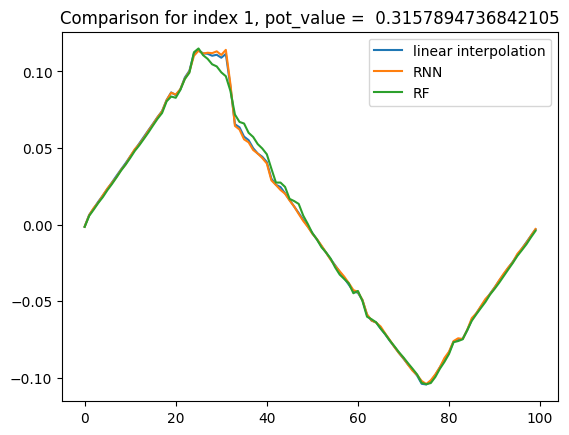

In [108]:
plt.plot(inter_pred_LI[1], label="linear interpolation")
plt.plot(inter_pred_RNN[1], label="RNN")
plt.plot(inter_pred_RF[1], label="RF")
plt.title("Comparison for index 1, pot_value =  0.3157894736842105")
plt.legend()
plt.show()

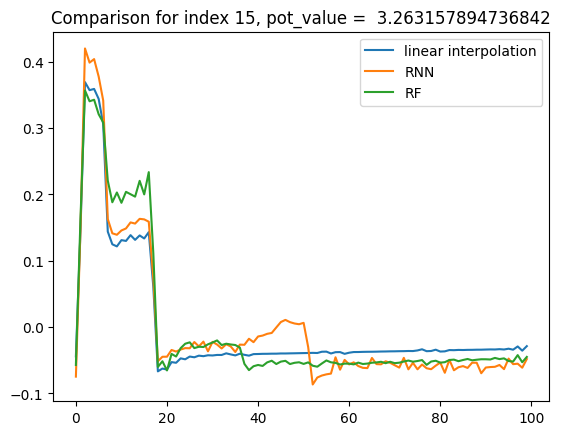

In [109]:
plt.plot(inter_pred_LI[15], label="linear interpolation")
plt.plot(inter_pred_RNN[15], label="RNN")
plt.plot(inter_pred_RF[15], label="RF")
plt.title("Comparison for index 15, pot_value =  3.263157894736842")
plt.legend()
plt.show()

In [105]:
print(pot_values)

[0.         0.21052632 0.42105263 0.63157895 0.84210526 1.05263158
 1.26315789 1.47368421 1.68421053 1.89473684 2.10526316 2.31578947
 2.52631579 2.73684211 2.94736842 3.15789474 3.36842105 3.57894737
 3.78947368 4.        ]


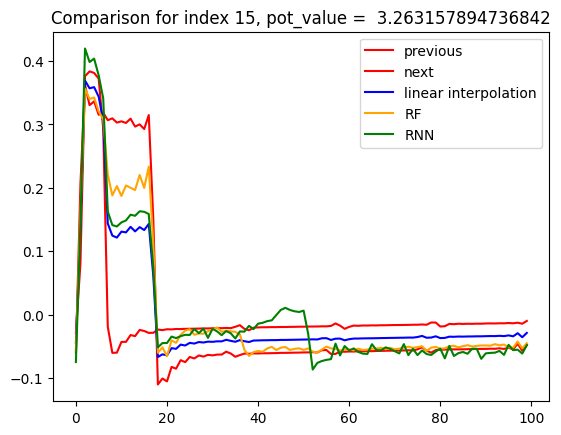

In [110]:
plt.plot(audios[15], label="previous", color="red")
plt.plot(audios[16], label="next", color="red")
plt.plot(inter_pred_LI[15], label="linear interpolation", color="blue")
plt.plot(inter_pred_RF[15], label="RF", color="orange")
plt.plot(inter_pred_RNN[15], label="RNN", color="green")
plt.title("Comparison for index 15, pot_value =  3.263157894736842")
plt.legend()
plt.show()